In [ ]:
# Tóm tắt những thay đổi
#
#   Gom các hàm của thuật toán DQN thành một class
#   Dùng Optuna để tune hyperparameters
#   Tham khảo hyperparameters đã được tune của rl-baseline3-zoo. Link: https://github.com/DLR-RM/rl-baselines3-zoo/blob/master/hyperparams/dqn.yml
#       Thay đổi cấu trúc neural giống với rl-baseline3-zoo với ít nút hơn
#       Xác định khoảng giá trị cho các hyperparameter xung quanh giá trị đã tune
#   Thiết lập Tự động lưu study của optuna, model, video
#

In [ ]:
!pip install gym pyvirtualdisplay
!apt-get install -y xvfb python-opengl
!apt-get install -y ffmpeg
!pip install colabgymrender==1.0.2
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-opengl is already the newest version (3.1.0+dfsg-1).
xvfb is already the newest version (2:1.19.6-1ubuntu4.10).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.o

In [ ]:
import os
from pathlib import Path
from google.colab import drive
import pickle

import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
from torchvision import datasets
from torchvision import transforms
import optuna
from optuna.trial import TrialState

import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt
from colabgymrender.recorder import Recorder

In [ ]:
drive_dir = '/content/drive'
drive.mount(drive_dir)
root = Path(drive_dir) / 'MyDrive/CS106-Assignment-6'

sym_dir = '/content/CS106-Assignment-6'
if not os.path.islink(sym_dir):
  os.symlink(str(root), sym_dir)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
class QNetwork(nn.Module):
    def __init__(self, env):
        super(QNetwork, self).__init__()
          
        layers = [
            nn.Linear(env.observation_space.shape[0], 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, env.action_space.n),
        ]
    
        self.network = nn.Sequential(*layers)
    
    def forward(self, state):
        return self.network(state)
    
    def choose_action(self, state):
        state = np.array(state)
        state = torch.tensor(state, dtype=torch.float32)
        q_values = self(state.unsqueeze(0)) # pytorch requires inputs in terms of batch
        best_action = torch.argmax(q_values, dim=1)[0]

        return best_action.detach().item()

In [ ]:
class DQN():
  def __init__(self, env, max_train_steps, max_epsilon, min_epsilon, epsilon_decay_intervals, gamma, memory_size, min_replay_size, batch_size, target_update_frequency, alpha, optimizer_name):
    self.env = env
    self.max_train_steps = max_train_steps
    self.max_epsilon = max_epsilon
    self.min_epsilon = min_epsilon
    self.epsilon_decay_intervals = epsilon_decay_intervals
    self.gamma = gamma
    self.memory_size = memory_size
    self.min_replay_size = min_replay_size
    self.batch_size = batch_size
    self.target_update_frequency = target_update_frequency
    self.alpha = alpha
    self.optimizer_name = optimizer_name

  def fill_memory(self):
    memory = deque(maxlen=self.memory_size)
    state = self.env.reset()
    for _ in range(self.min_replay_size):
        action = self.env.action_space.sample()
        next_state, reward, done, info = self.env.step(action)
        experience = (state, action, reward, done, next_state)
        memory.append(experience)
        state = next_state
        if done:
            self.env.reset()
    
    return memory

  def train(self):
    self.q_net = QNetwork(env)
    self.target_net = QNetwork(env)
    optimizer = getattr(optim, self.optimizer_name)(self.q_net.parameters(), lr=self.alpha)
    self.target_net.load_state_dict(self.q_net.state_dict())

    memory = self.fill_memory()
    reward_buffer = deque(maxlen=100) # Rewards of the previous 100 episodes

    reward_per_episode = 0.0
    state = self.env.reset()
    self.all_rewards = []
    for step in range(self.max_train_steps):
        epsilon = np.interp(step, [0, self.epsilon_decay_intervals], [self.max_epsilon, self.min_epsilon])

        random_number = np.random.uniform(0,1)
        if random_number <= epsilon:
            action = self.env.action_space.sample()
        else:
            action = self.q_net.choose_action(state)
        
        next_state, reward, done, info = self.env.step(action)
        experience = (state, action, reward, done, next_state)
        memory.append(experience)
        reward_per_episode += reward

        state = next_state

        if done:
            state = self.env.reset()
            reward_buffer.append(reward_per_episode)
            self.all_rewards.append((step, reward_per_episode))
            reward_per_episode = 0.0

        # Take a batch of experiences from the memory
        experiences = random.sample(memory, self.batch_size)
        states = np.array([ex[0] for ex in experiences])
        actions = np.array([ex[1] for ex in experiences])
        rewards = np.array([ex[2] for ex in experiences])
        dones = np.array([ex[3] for ex in experiences])
        next_states = np.array([ex[4] for ex in experiences])

        states = torch.tensor(states, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.int64).unsqueeze(-1) # (batch_size,) --> (batch_size, 1)
        rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(-1)
        dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(-1)
        next_states = torch.tensor(next_states, dtype=torch.float32)

        # Compute targets using the formulation sample = r + gamma * max q(s',a')
        target_q_values = self.target_net(next_states)
        max_target_q_values = target_q_values.max(dim=1, keepdim=True)[0]
        targets = rewards + self.gamma * (1-dones) * max_target_q_values

        # Compute loss
        q_values = self.q_net(states)

        action_q_values = torch.gather(input=q_values, dim=1, index=actions)
        loss = torch.nn.functional.mse_loss(action_q_values, targets)

        # gradient descent for q-network
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # update target network
        if (step+1) % self.target_update_frequency == 0:
            self.target_net.load_state_dict(self.q_net.state_dict())

        # print training results
        if (step+1) % 1000 == 0:
            average_reward = np.mean(reward_buffer)
            print(f'Episode: {len(self.all_rewards)} Step: {step+1} Average reward: {average_reward}')
    
    return self.all_rewards, self.q_net

In [ ]:
def evaluate(env, q_net):
  state = env.reset()
  done = False
  total_reward = 0.0
  q_net.eval()

  with torch.no_grad():
      while not done:
          action = q_net.choose_action(state)
          next_state, reward, done, info = env.step(action)
          total_reward += reward
          state = next_state

  return(total_reward)

In [ ]:
def objective(trial):
    global env, max_trial_train_steps, unsaved_study

    # Generate the hyperparameters
    alpha = trial.suggest_float("alpha", 4e-4, 4e-2)
    min_epsilon = trial.suggest_float("min_epsilon", 1e-2, 1e-1)
    max_epsilon = trial.suggest_float("max_epsilon", 1e-1, 1)
    gamma = trial.suggest_float("gamma", 0.96, 1)
    epsilon_decay_intervals = trial.suggest_int("epsilon_decay_intervals", 5000, 15000)
    batch_size = trial.suggest_int("batch_size", 80, 150)
    min_replay_size = trial.suggest_int("min_replay_size", 800, 1200)
    memory_size = trial.suggest_int("memory_size", 8000, 12000)
    target_update_frequency = trial.suggest_int("target_update_frequency", 600, 1500)
    optimizer_name = trial.suggest_categorical("optimizer_name", ["Adam", "RMSprop", "SGD"])

    # Training
    model = DQN(env, max_trial_train_steps, max_epsilon, min_epsilon, epsilon_decay_intervals, gamma, memory_size, min_replay_size, batch_size, target_update_frequency, alpha, optimizer_name)
    all_rewards, q_net = model.train()

    # Evaluation
    score = 0.5 * evaluate(env, q_net) + 0.5 * np.mean([x[1] for x in all_rewards])

    # Saving study variable
    unsaved_study += 1
    unsaved_study %= 2
    if unsaved_study == 0:
      with open(str(root / "study.txt"), "wb") as f:
        pickle.dump(study, f)

    return score

In [ ]:
env = gym.make('MountainCar-v0')
n_trials = 111
max_train_steps = 120000
max_trial_train_steps = 50000
unsaved_study = 0

with open(str(root / "study.txt"), "rb") as f:
  study = pickle.load(f)

# study = optuna.create_study(direction="maximize")

In [ ]:
while True:
  study.optimize(objective, n_trials=n_trials, timeout=600)

In [ ]:
print('Best value:', study.best_value)
print('Best hyperparameters:')
for key, value in study.best_params.items():
    globals()[key] = value
    print(f'\t\t\t{key}: {value}')

Best value: -135.36080586080584
Best hyperparameters:
			alpha: 0.005054195193774878
			min_epsilon: 0.04379220830329905
			max_epsilon: 0.1957918533704745
			gamma: 0.990285630748527
			epsilon_decay_intervals: 7291
			batch_size: 99
			min_replay_size: 819
			memory_size: 9871
			target_update_frequency: 812
			optimizer_name: Adam


In [ ]:
model = DQN(env, max_train_steps, max_epsilon, min_epsilon, epsilon_decay_intervals, gamma, memory_size, min_replay_size, batch_size, target_update_frequency, alpha, optimizer_name)
model.train()
with open(str(root / 'model.txt'), 'wb') as f:
  pickle.dump(model, f)

Episode: 5 Step: 1000 Average reward: -200.0
Episode: 10 Step: 2000 Average reward: -200.0
Episode: 15 Step: 3000 Average reward: -200.0
Episode: 20 Step: 4000 Average reward: -200.0
Episode: 25 Step: 5000 Average reward: -200.0
Episode: 30 Step: 6000 Average reward: -200.0
Episode: 35 Step: 7000 Average reward: -200.0
Episode: 40 Step: 8000 Average reward: -200.0
Episode: 45 Step: 9000 Average reward: -200.0
Episode: 50 Step: 10000 Average reward: -200.0
Episode: 55 Step: 11000 Average reward: -200.0
Episode: 60 Step: 12000 Average reward: -200.0
Episode: 65 Step: 13000 Average reward: -200.0
Episode: 70 Step: 14000 Average reward: -200.0
Episode: 75 Step: 15000 Average reward: -200.0
Episode: 80 Step: 16000 Average reward: -200.0
Episode: 85 Step: 17000 Average reward: -200.0
Episode: 90 Step: 18000 Average reward: -200.0
Episode: 95 Step: 19000 Average reward: -200.0
Episode: 100 Step: 20000 Average reward: -200.0
Episode: 105 Step: 21000 Average reward: -200.0
Episode: 110 Step: 22

In [ ]:
with open(str(root / 'model.txt'), 'rb') as f:
  model = pickle.load(f)
all_rewards = model.all_rewards
q_net = model.q_net

In [ ]:
!rm -r {root}/video
env = Recorder(env, str(root / 'video'))

state = env.reset()
done = False
total_reward = 0.0
q_net.eval()

with torch.no_grad():
    while not done:
        action = q_net.choose_action(state)
        next_state, reward, done, info = env.step(action)
        total_reward += reward
        state = next_state

print(total_reward)
env.play()

-85.0


100%|██████████| 87/87 [00:00<00:00, 370.39it/s]


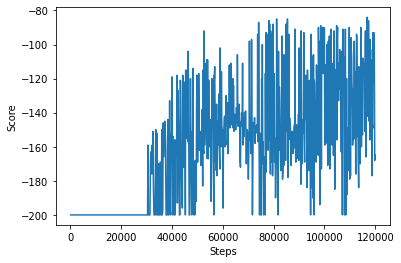

In [ ]:
all_rewards = np.array(all_rewards)
plt.xlabel('Steps')
plt.ylabel('Score')
plt.plot(all_rewards[:, 0], all_rewards[:, 1])